Настало время внести улучшения в бейзлайн!

Склонируем [ноутбук с бейзлайном](https://www.kaggle.com/alexryzhkov/lightautoml-competition-baseline) при помощи кнопки Copy & Edit в правом верхнем углу. Не забудьте переименовать для удобства.

Шаги с установкой библиотеки LAMA, определением констант, загрузкой данных, подготовкой признаков не нуждаются в изменениях. 

А вот определение задачи (Task) требует нашего пристального внимания. 

Согласно условиям соревнования, метрикой оценки качества является MAE. 

А в нашем бейзлайне в качестве метрики указана MSE: 

In [3]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [4]:
# Далее определяем константы (количество потоков, таймаут, имя целевой колонки, размер валидационной выборки и так далее).
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600 # equal to 10 minutes
TARGET_NAME = 'final_price'

In [5]:
# Для максимальной воспроизводимости решения используем команды:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [6]:
# Указываем путь к папке с данными:
#INPUT_DIR = '../input/sf-dst-predict-car-price/'
INPUT_DIR = 'data/'

In [7]:
# Загружаем тренировочный датасет (в нём будет 15 колонок):
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [8]:
# Загружаем тестовый датасет (в нём будет 14 колонок, без колонки с целевой переменной):
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [9]:
# Загружаем шаблон сабмита (по количеству строк совпадает с тестовыми данными):
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


In [11]:
# Далее в бейзлайне идёт небольшая заготовка для генерации дополнительных признаков.
#%%time

from sklearn import preprocessing
import category_encoders as ce

def create_expert_feats(data):
    # инициализируем нормализатор RobustScaler
    r_scaler = preprocessing.RobustScaler()

    # кодируем исходный датасет
    df_r = r_scaler.fit_transform(data[['current_mileage']])
    
    # Преобразуем промежуточный датасет в полноценный датафрейм
    df_r = pd.DataFrame(df_r)
    data['current_mileage'] = df_r[0]
    
    # Создадим новые признаки методом Однократного кодирование 
    data = pd.get_dummies(data, columns=['vehicle_gearbox_type', 'wheels', 'vehicle_category', 'vehicle_color', 'vehicle_interior_color', 'doors_cnt'])
        
    # Удаляем выбросы Методом z-отклонения:
    mu = data['vehicle_year'].mean()
    sigma = data['vehicle_year'].std()
    lower_bound = mu - sigma
    data = data[data['vehicle_year'] > lower_bound]
    data = data[data['deal_type'] == 'For Sale']
    
    # Создадим новые признаки методом двоичного кодирования
    bin_encoder = ce.BinaryEncoder(cols=['vehicle_year']) # указываем столбец для кодирования
    type_bin = bin_encoder.fit_transform(data['vehicle_year'])
    data = pd.concat([data, type_bin], axis=1)
    
    # Удаляем данные с редкими производителями
    popular_vehicle_manufacturer = test_data['vehicle_manufacturer'].value_counts().nlargest(50).index
    data = data[data['vehicle_manufacturer'].apply(lambda x: x in popular_vehicle_manufacturer)]
    
    return data

create_expert_feats(train_data)
create_expert_feats(test_data)

,row_ID,vehicle_manufacturer,vehicle_model,current_mileage,vehicle_year,car_vin,car_leather_interior,deal_type,vehicle_gearbox_type_Automatic,vehicle_gearbox_type_Manual,...,vehicle_interior_color_ White,vehicle_interior_color_ Yellow,doors_cnt_ 2/3,doors_cnt_ 4/5,doors_cnt_ >5,vehicle_year_0,vehicle_year_1,vehicle_year_2,vehicle_year_3,vehicle_year_4
0,35000,TOYOTA,Prius,1.629153,2012,JTDKN3DU6C5439638,1,For Sale,1,0,...,0,0,0,1,0,0,0,0,0,1
1,35001,HYUNDAI,Elantra,-0.133174,2013,SURATSHIA,1,For Sale,0,0,...,0,0,0,1,0,0,0,0,1,0
2,35002,LEXUS,NX 300,-0.924557,2018,JTJYARBZ5J2104521,1,For Sale,1,0,...,0,0,0,0,0,0,0,0,1,1
3,35003,LEXUS,CT 200h,1.454438,2012,JTHKD5BH4C2070945,1,For Sale,1,0,...,0,0,0,1,0,0,0,0,0,1
4,35004,TOYOTA,RAV 4,-1.050406,2002,NaN,0,For Sale,0,1,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692,45692,INFINITI,EX30,1.595169,2010,JN1AJ0HR9AM751454,1,For Sale,1,0,...,0,0,0,0,0,0,0,1,1,1
10693,45693,MERCEDES-BENZ,E 350,-0.168132,2013,WDDHF5KB8DA732315,1,For Sale,1,0,...,0,0,0,1,0,0,0,0,1,0
10694,45694,LAND ROVER,Land Rover Sport,0.183114,2011,NaN,1,For Sale,0,0,...,0,0,0,1,0,0,1,0,0,0
10695,45695,TOYOTA,Prius,0.183114,2010,NaN,0,For Sale,0,0,...,1,0,0,1,0,0,0,1,1,1


In [16]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (28000, 15), te_data = (7000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
18788,18788,HYUNDAI,Santa FE,Jeep,0.410971,2010,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,7464.0
776,776,HYUNDAI,Santa FE,Jeep,0.119498,2011,Automatic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,5959.0
480,480,BMW,X5 XDRIVE35 D,Jeep,0.168711,2015,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Sale,23900.0
30078,30078,CHRYSLER,300,Sedan,0.041368,2014,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,1750.0
29115,29115,TOYOTA,4Runner,Jeep,-1.088185,2018,Automatic,4/5,Left wheel,Black,Black,NaN,1,For Sale,100.0


In [17]:
# В нашем случае мы решаем задачу регрессии (подробнее с регрессией мы познакомимся в следующих модулях). Также указываем метрику.
task = Task('reg', loss = 'mae', metric = 'mae')

In [18]:
# Далее необходимо указать роли переменных: сказать библиотеке, какая колонка является целевой. Кроме того, укажем на то, что колонку row_ID можно опустить.
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID', 'vehicle_gearbox_type', 'wheels', 'vehicle_category', 'vehicle_color', 'vehicle_interior_color', 'doors_cnt']
}

In [19]:
# Наш итоговый код: 
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

## 2. AutoML training

In [20]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[20:04:31] Stdout logging level is INFO.
[20:04:31] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[20:04:31] Task: reg

[20:04:31] Start automl preset with listed constraints:
[20:04:31] - time: 600.00 seconds
[20:04:31] - CPU: 4 cores
[20:04:31] - memory: 16 GB

[20:04:31] Train data shape: (28000, 15)

[20:04:41] Layer 1 train process start. Time left 589.33 secs
[20:04:44] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[20:05:11] Time limit exceeded after calculating fold 3

[20:05:11] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3682.111696930272
[20:05:11] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[20:05:11] Time left 559.64 secs



c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\User\AppData\Local\Programs\Python\Pytho

[20:05:17] Selector_LightGBM fitting and predicting completed
[20:05:19] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[20:05:49] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -2762.4890448057367
[20:05:49] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[20:05:49] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 8.14 secs
[20:06:04] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[20:06:04] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[20:07:12] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -2630.88456317913
[20:07:12] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[20:07:13] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[20:08:18] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -2821.897627408201
[20:08:18] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[20:08:18] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 16.96 secs
[20:08:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost complet

In [21]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.91358 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.08642 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


## 3. Prediction on holdout and model evaluation

In [22]:
# Следующий этап — обучение валидационной выборки. 
#%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[3027.6194 ],
       [6276.3438 ],
       [  70.77209],
       ...,
       [6478.252  ],
       [5351.708  ],
       [4805.5806 ]], dtype=float32)
Shape = (7000, 1)


In [23]:
# Измеряем качество модели, сравнивая MAE на тренировочной и валидационной выборках:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 2629.9023497874928
HOLDOUT score: 2880.353799186979


## 4. Feature importances calculation

CPU times: total: 141 ms
Wall time: 157 ms


<Axes: xlabel='Feature'>

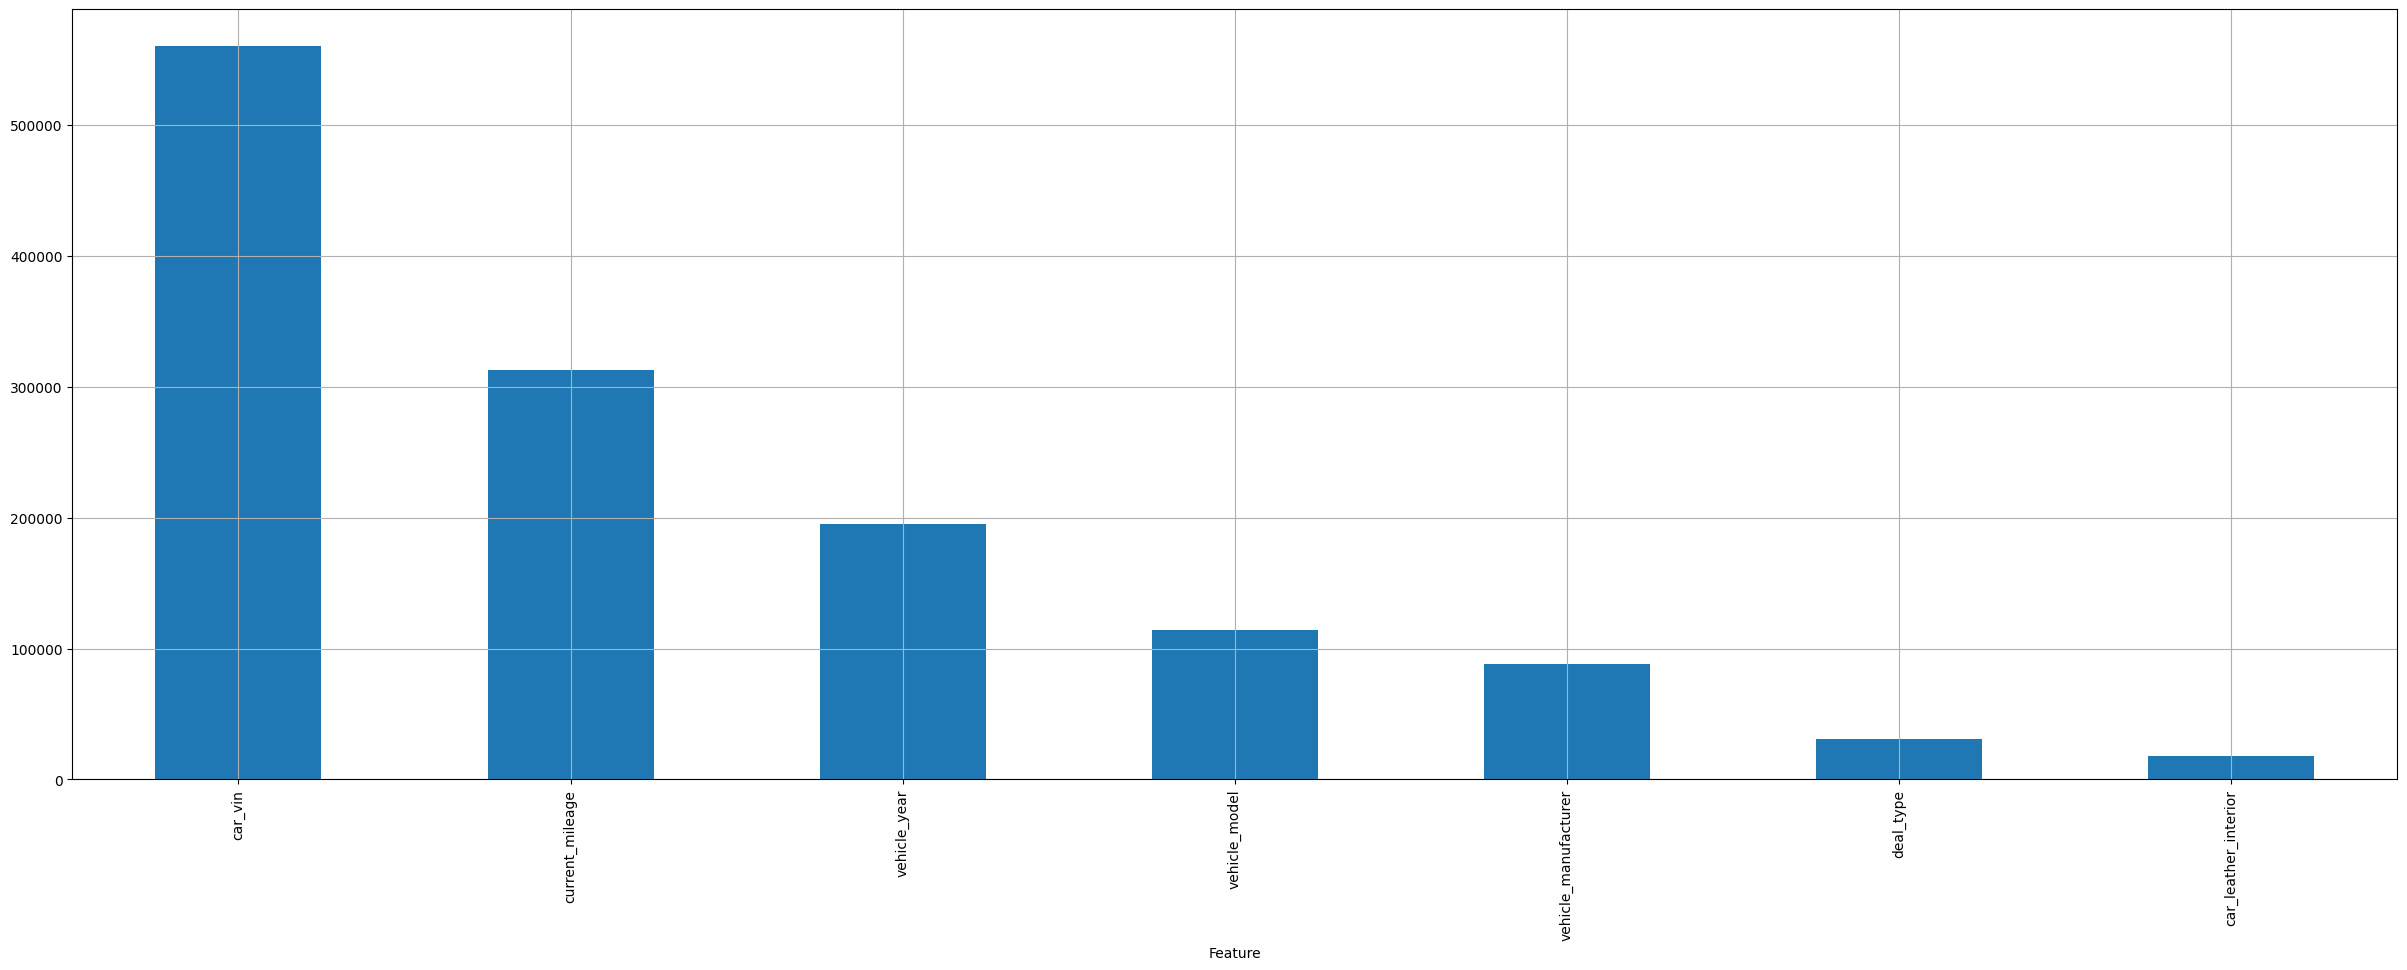

In [24]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [25]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: total: 1min 38s
Wall time: 27.3 s


<Axes: xlabel='Feature'>

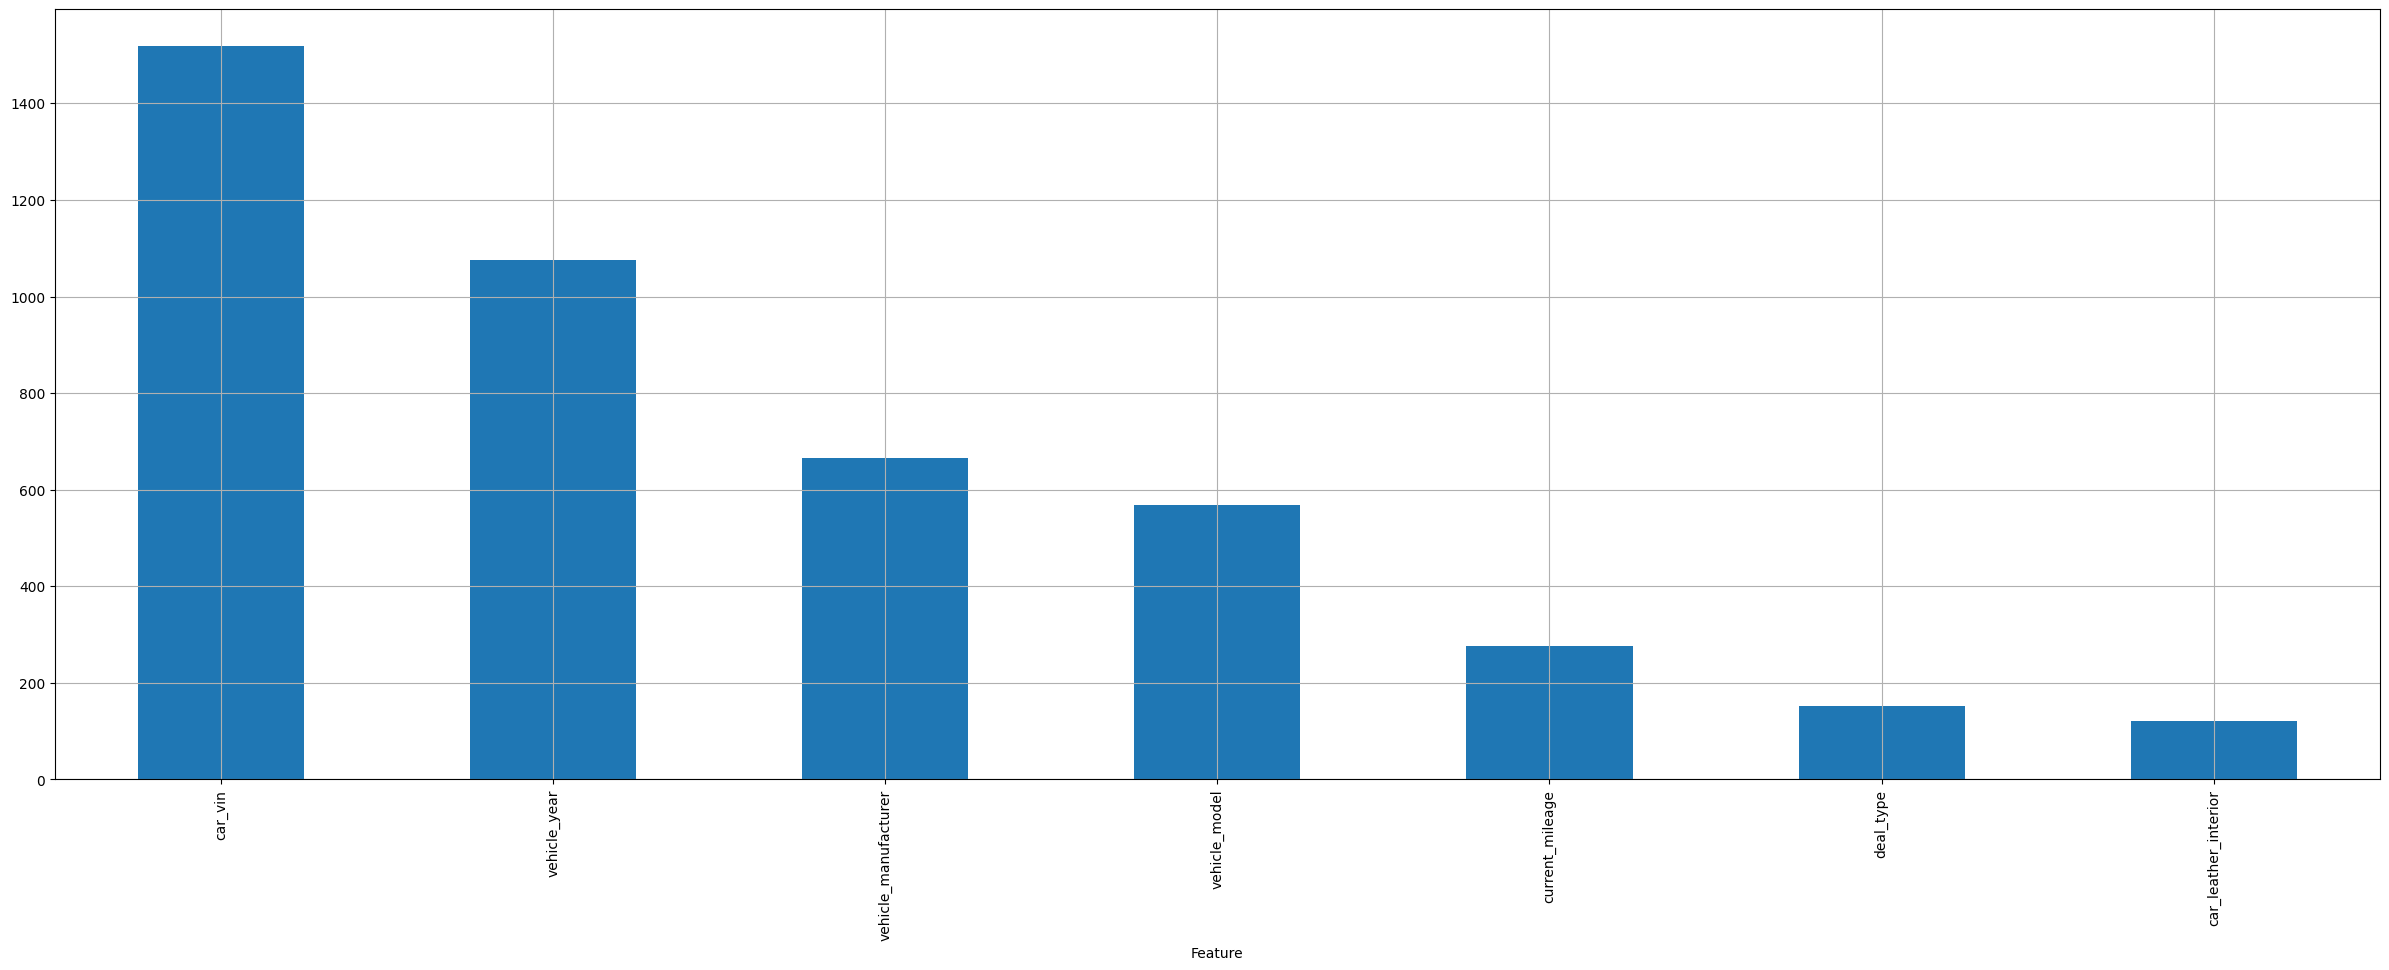

In [26]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

## 5. Predict for test dataset

In [27]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2841.8823],
       [ 2867.2283],
       [ 3406.957 ],
       ...,
       [14270.8545],
       [ 5331.3384],
       [ 6754.638 ]], dtype=float32)
Shape = (10697, 1)


In [28]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_my_first_version.csv', index = False)